In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import matplotlib
from numba import njit 
import scienceplots
plt.style.use(['science'])
plt.rcParams.update({'font.size': 20, 'font.weight': 'bold', 'font.family': 'sans-serif'})

In [2]:
# euler maryuma for simulating a brownian gyrator
@njit
def brownian_gyrator(k, alpha, T, eta, ini, dt, nsteps):
    x = np.zeros(nsteps)
    y = np.zeros(nsteps)
    kx = k[0]
    ky = k[1]
    x[0] = ini[0]
    y[0] = ini[1]
    eta_x = eta[0]
    eta_y = eta[1]
    Tx = T[0]
    Ty = T[1]
    for i in range(1, nsteps):
        x[i] = x[i-1] + dt*(-1/eta_x)*(kx*(np.cos(alpha)*x[i-1] + ky*np.sin(alpha)*y[i-1])*np.cos(alpha) - ky*(np.cos(alpha)*y[i-1] - np.sin(alpha)*x[i-1])*np.sin(alpha)) + np.sqrt(2*Tx/eta_x)*np.random.normal(0, dt)
        y[i] = y[i-1] + dt*(-1/eta_y)*(-kx*(np.cos(alpha)*x[i-1] + ky*np.sin(alpha)*y[i-1])*np.sin(alpha) + ky*(np.cos(alpha)*y[i-1] - np.sin(alpha)*x[i-1])*np.cos(alpha)) + np.sqrt(2*Ty/eta_y)*np.random.normal(0, dt)
    
    return x, y

In [3]:
# new brownian gyrator with a constraint. 
@njit
def bgyrator(k,alpha,T,eta,ini,dt,nsteps):
    x = np.zeros((nsteps,2))
    A = np.zeros((2,2))
    B = np.zeros((2,2))
    A[0,0] = k/eta
    A[0,1] = alpha/eta
    A[1,0] = alpha/eta
    A[1,1] = k/eta
    
    B[0,0] = np.sqrt(2*T[0]/eta)
    B[1,1] = np.sqrt(2*T[1]/eta)
    
    x[0] = ini
    
    for i in range(1,nsteps):
        xi = np.random.normal(0,dt,(2,))
        x[i] = x[i-1] - dt*(A @ x[i-1]) + B @ xi
    return x

    
    

In [351]:
# Underdamped brownian gyrator 
@njit
def ubgyrator(k,alpha,m,T,eta,ini,dt,nsteps):
    A = np.zeros((4,4))
    B = np.zeros((4,4))
    x = np.zeros((nsteps,4))
    A[0,2] = 1/m
    A[1,3] = 1/m
    A[2,0] = -k
    A[2,1] = -alpha
    A[2,2] = -eta/m
    A[3,0] = -alpha
    A[3,1] = -k
    A[3,3] = -eta/m
    B[2,2] = np.sqrt(2*T[0]*eta/m**2)
    B[3,3] = np.sqrt(2*T[1]*eta/m**2)
    x[0] = ini
    for i in range(1,nsteps):
        xi = np.random.normal(0,dt,(4,))
        x[i] = x[i-1] + dt*(A @ x[i-1]) + B @ xi
    return x,A,B
    
    

In [ ]:
# Underdamped brownian gyrator 
@njit
def ubgyrator_imp(k,u,m,T,eta,ini,dt,nsteps):
    F = np.zeros((4,4))
    B = np.zeros((4,4))
    x = np.zeros((nsteps,4))
    xt = np.zeros((nsteps,4))
    F[0,2] = k
    
    B[2,2] = np.sqrt(2*T[0]*eta/m**2)
    B[3,3] = np.sqrt(2*T[1]*eta/m**2)
    x[0] = ini
    alpha = 1-np.exp(-eta*dt)
    for i in range(1,nsteps):
        xi = np.random.normal(0,dt,(4,))
        
        x[i] = x[i-1] - dt*(A @ x[i-1]) + B @ xi
    return x,A,B
    

In [258]:
%%time
ini = [1.0, 0.0]
k = [1.0, 2.0]
T = [0.01, 5.0]
# T = [0,0]
eta = [1.0, 5.0]
alpha = np.pi/4
dt = 0.01
nsteps = 3000
x, y = brownian_gyrator(k, alpha, T, eta, ini, dt, nsteps)

CPU times: user 566 μs, sys: 0 ns, total: 566 μs
Wall time: 579 μs


In [443]:
%time
ini = [.01, 0.0, 0.1, 0.]
ini2 = [0.1, 0.0]
k = 10.0
m = 1.0
T = [10000.0, 1.0]
eta = 1.0
alpha = 3.0
dt = 0.001
nsteps = 50000
trajectory,A,B = ubgyrator(k, alpha, m, T,eta, ini, dt, nsteps)
# ovd_trajectory = bgyrator(k, alpha, T, eta, ini2, dt, nsteps)


CPU times: user 6 μs, sys: 1 μs, total: 7 μs
Wall time: 9.3 μs


In [444]:
A,B

(array([[  0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   1.],
        [-10.,  -3.,  -1.,   0.],
        [ -3., -10.,   0.,  -1.]]),
 array([[  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        , 141.42135624,   0.        ],
        [  0.        ,   0.        ,   0.        ,   1.41421356]]))

In [445]:
# Determine plot limits based on trajectory with some padding
x_min, x_max = trajectory[:, 0].min(), trajectory[:, 0].max()
y_min, y_max = trajectory[:, 1].min(), trajectory[:, 1].max()
padding = 0.06
x_range = (x_min - 2*padding, x_max + 2*padding)
y_range = (y_min - padding, y_max + padding)

# Generate potential contour data
X, Y, Z = generate_potential_grid(k, alpha, x_range, y_range, n_points=200)

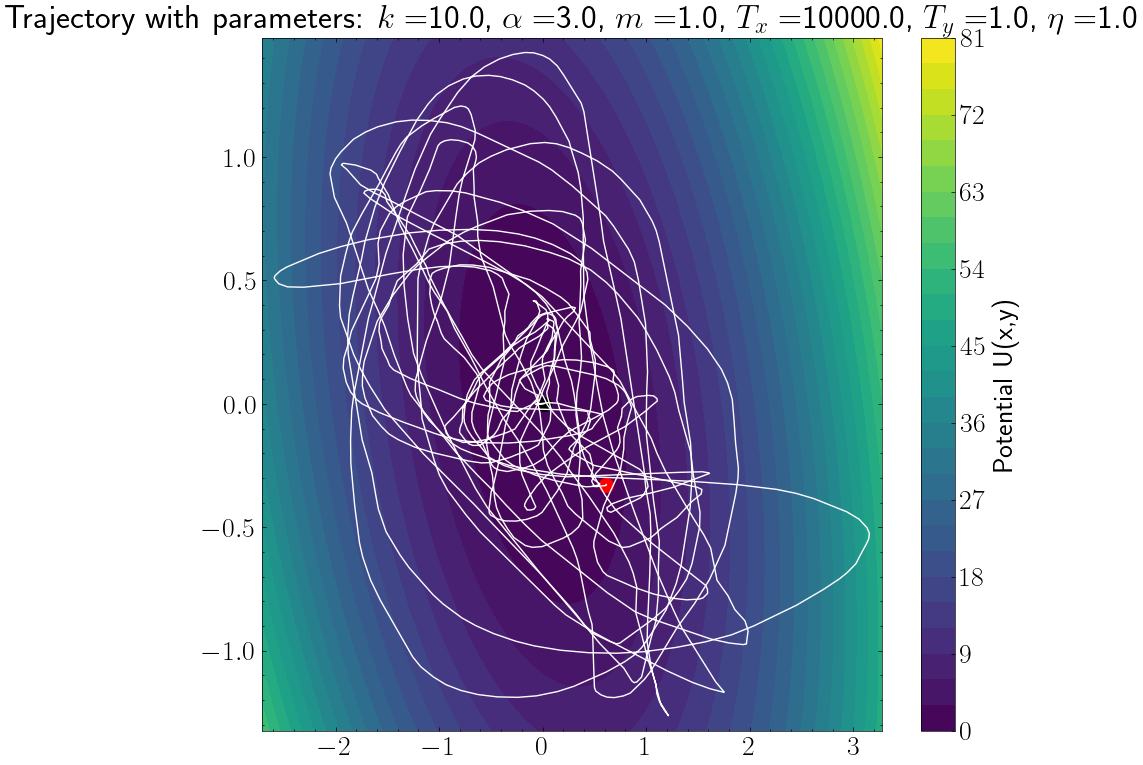

In [446]:
plt.figure(figsize=(10, 9))
contour = plt.contourf(X, Y, Z, levels=30, cmap='viridis')
plt.colorbar(contour, label='Potential U(x,y)')
plt.plot(trajectory[:, 0], trajectory[:, 1], color='white', lw=1)
plt.scatter(trajectory[0, 0], trajectory[0, 1], color='black', s=100, label='Start')
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=100, label='End')
plt.title(r'Trajectory with parameters: $k=$'+str(k)+r', $\alpha=$'+str(alpha)+r', $m=$'+str(m)+r', $T_x=$'+str(T[0])+r', $T_y=$'+str(T[1])+r', $\eta=$'+str(eta))
plt.savefig("images/gyrator/udgyrator_trajectory_DTlarge_5_long.png", dpi=300)

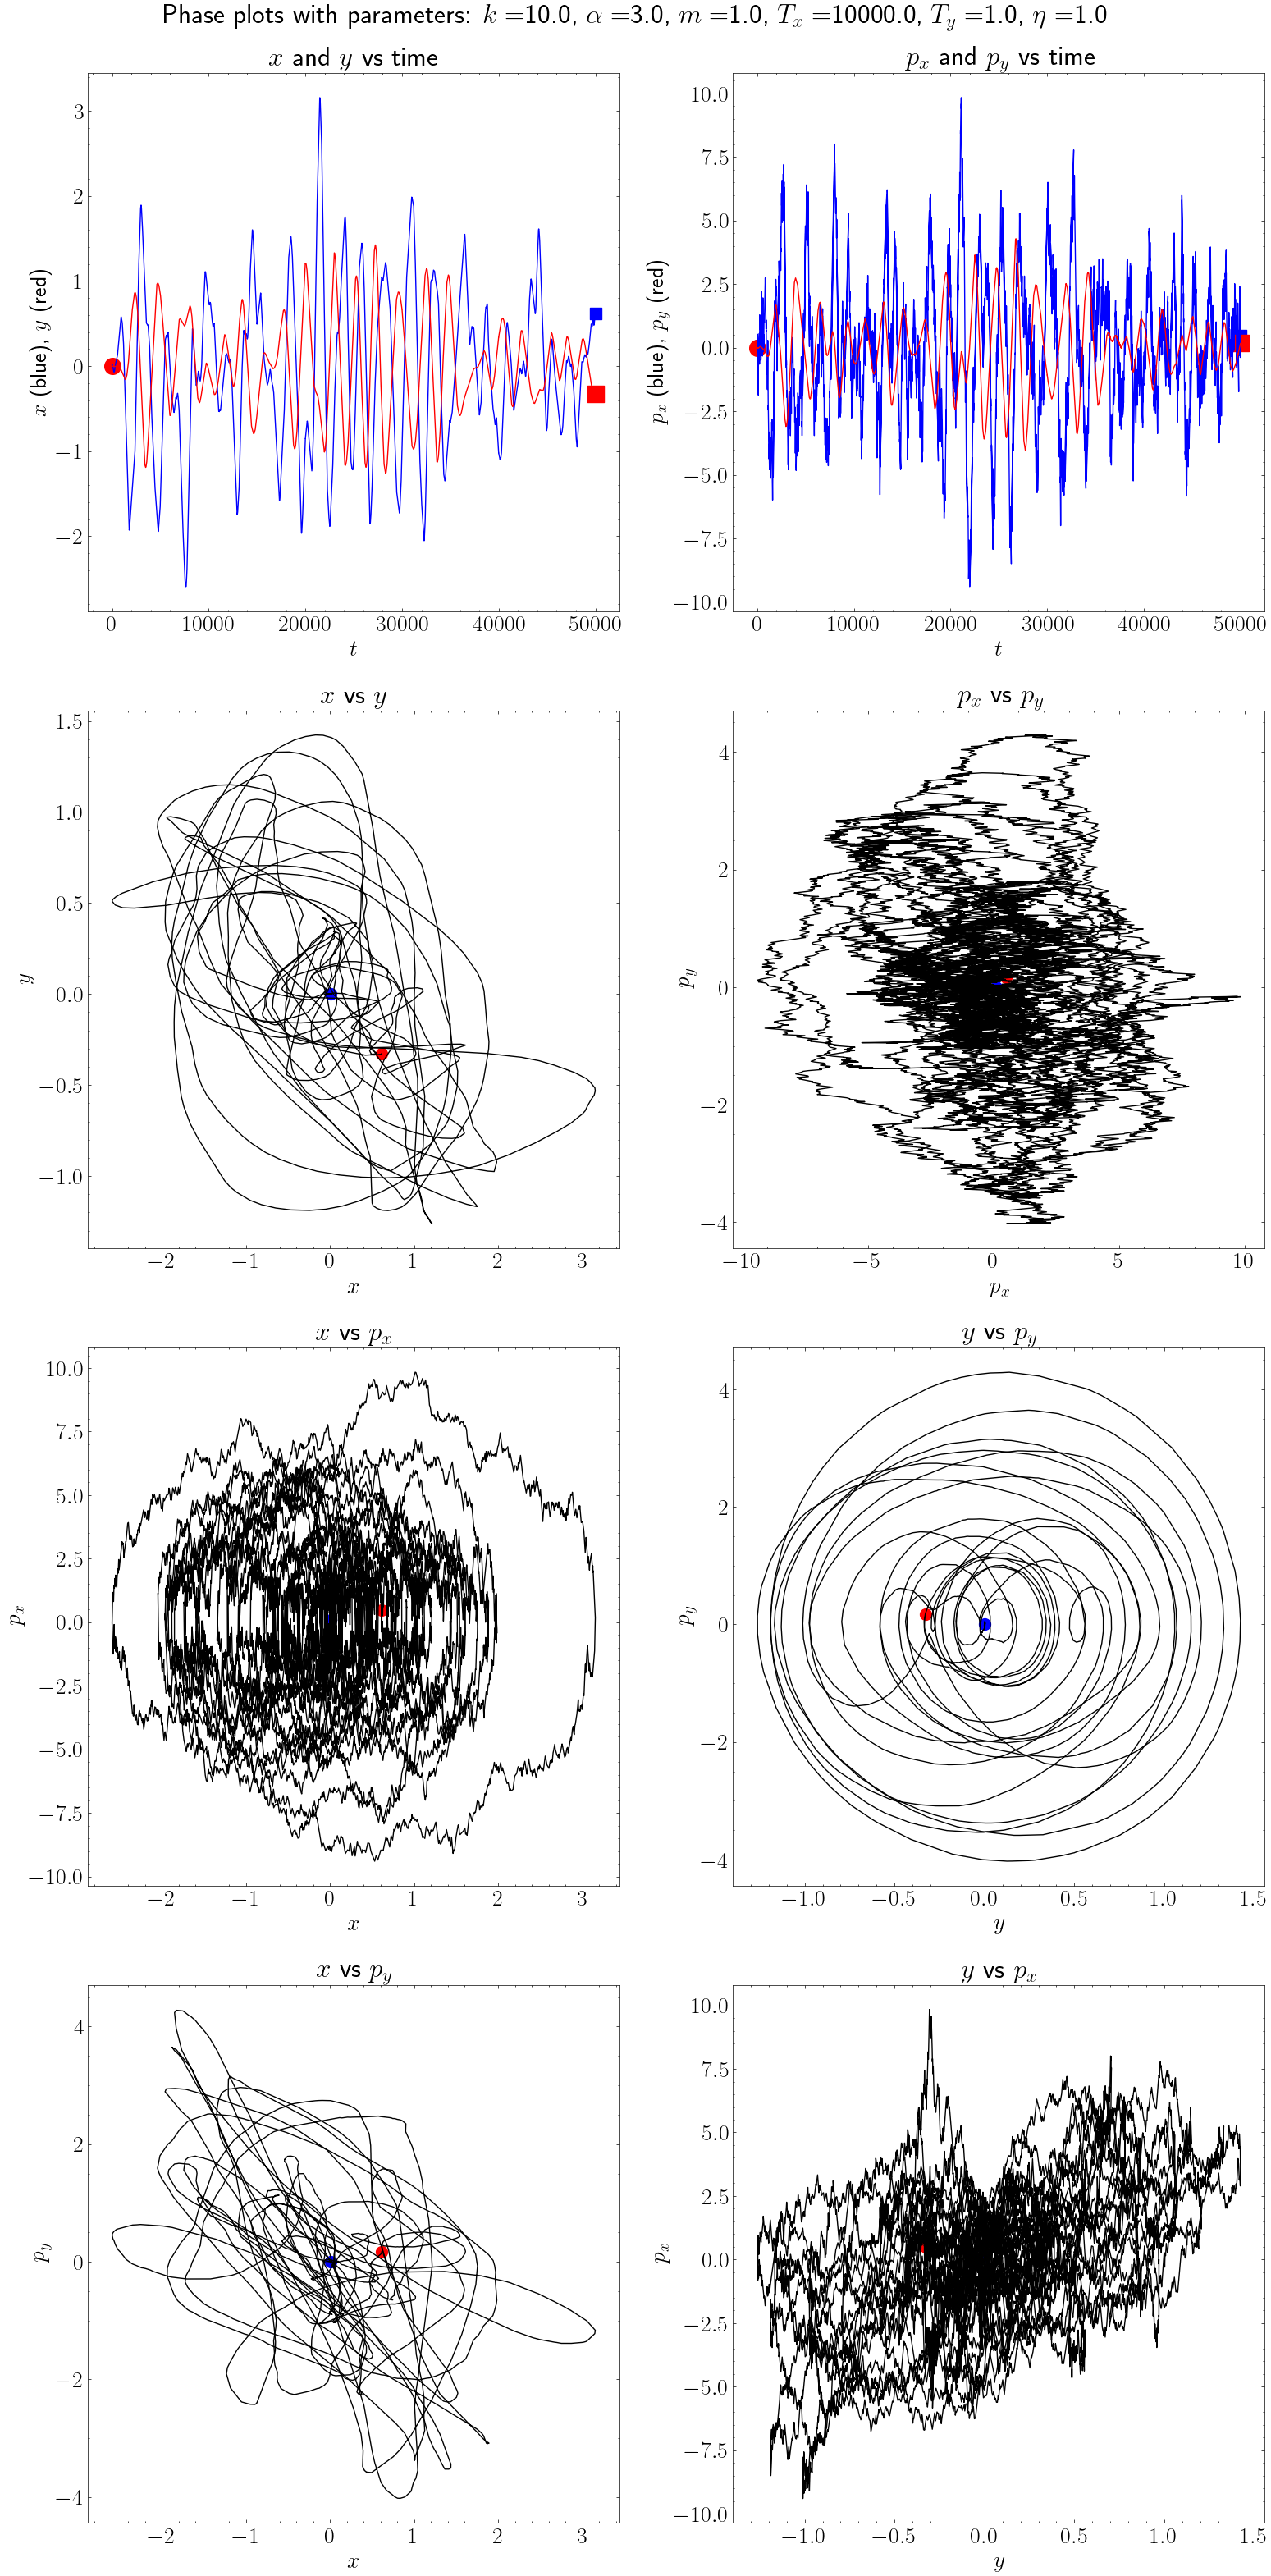

In [447]:
fig,axes = plt.subplots(4,2,figsize=(16,32), tight_layout=True)

ax = axes[0,0]
ax.plot(np.arange(0,nsteps), trajectory[:, 0], color='b', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 1], color='r', lw=1)
ax.scatter(0, trajectory[0, 0], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 0], marker='s',color='b', s=100, label='End')
ax.scatter(0, trajectory[0, 1], color='r', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 1],marker='s', color='r', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$ (blue), $y$ (red)')
ax.set_title(r'$x$ and $y$ vs time')

ax = axes[0,1]
ax.plot(np.arange(0,nsteps), trajectory[:, 2], color='b', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 3], color='r', lw=1)
ax.scatter(0, trajectory[0, 2], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 2],marker='s', color='b', s=100, label='End')
ax.scatter(0, trajectory[0, 3], color='r', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 3],marker='s', color='r', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$p_x$ (blue), $p_y$ (red)')
ax.set_title(r'$p_x$ and $p_y$ vs time')

ax = axes[1,0]
ax.plot( trajectory[:, 0], trajectory[:, 1], color='k', lw=1)
ax.scatter(trajectory[0, 0], trajectory[0, 1], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 0], trajectory[-1, 1], color='r', s=100, label='End')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'$x$ vs $y$')

ax = axes[1,1]
ax.plot( trajectory[:, 2], trajectory[:, 3], color='k', lw=1)
ax.scatter(trajectory[0, 2], trajectory[0, 3], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 2], trajectory[-1, 3], color='r', s=100, label='End')
ax.set_xlabel(r'$p_x$')
ax.set_ylabel(r'$p_y$')
ax.set_title(r'$p_x$ vs $p_y$')

ax = axes[2,0]
ax.plot( trajectory[:, 0], trajectory[:, 2], color='k', lw=1)
ax.scatter(trajectory[0, 0], trajectory[0, 2], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 0], trajectory[-1, 2], color='r', s=100, label='End')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_x$')
ax.set_title(r'$x$ vs $p_x$')

ax = axes[2,1]
ax.plot( trajectory[:, 1], trajectory[:, 3], color='k', lw=1)
ax.scatter(trajectory[0, 1], trajectory[0, 3], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 1], trajectory[-1, 3], color='r', s=100, label='End')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$p_y$')
ax.set_title(r'$y$ vs $p_y$')

ax = axes[3,0]
ax.plot( trajectory[:, 0], trajectory[:, 3], color='k', lw=1)
ax.scatter(trajectory[0, 0], trajectory[0, 3], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 0], trajectory[-1, 3], color='r', s=100, label='End')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p_y$')
ax.set_title(r'$x$ vs $p_y$')


ax = axes[3,1]
ax.plot( trajectory[:, 1], trajectory[:, 2], color='k', lw=1)
ax.scatter(trajectory[0, 1], trajectory[0, 2], color='b', s=100, label='Start')
ax.scatter(trajectory[-1, 1], trajectory[-1, 2], color='r', s=100, label='End')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$p_x$')
ax.set_title(r'$y$ vs $p_x$')

fig.suptitle(r'Phase plots with parameters: $k=$'+str(k)+r', $\alpha=$'+str(alpha)+r', $m=$'+str(m)+r', $T_x=$'+str(T[0])+r', $T_y=$'+str(T[1])+r', $\eta=$'+str(eta), verticalalignment='baseline', fontsize=24)

fig.savefig('images/gyrator/udgyrator_phase_DTlarge_5_long.png', dpi=300)

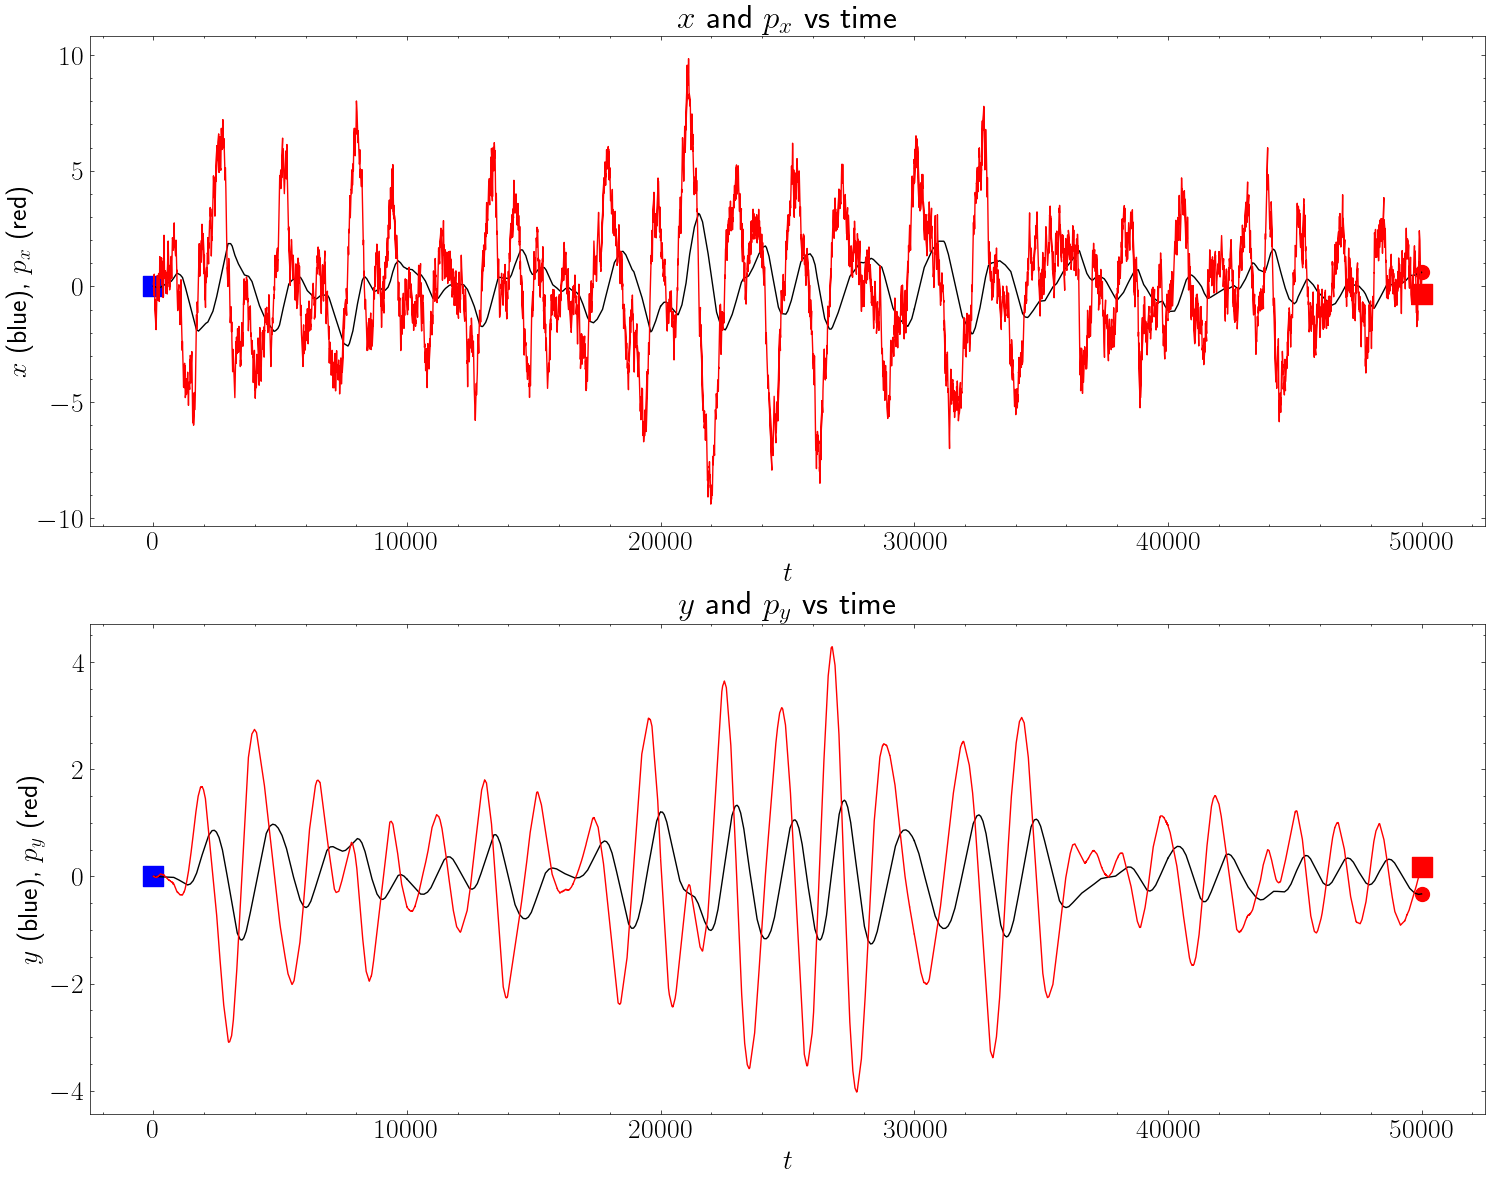

In [451]:
fig,axes = plt.subplots(2,1,figsize=(18, 14))
ax = axes[0]
ax.plot(np.arange(0,nsteps), trajectory[:, 0], color='black', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 2], color='r', lw=1)
ax.scatter(0, trajectory[0, 0], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 0], color='red', s=100, label='End')
ax.scatter(0, trajectory[0, 1],marker='s', color='b', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 1],marker='s', color='red', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$ (blue), $p_x$ (red)')
ax.set_title(r'$x$ and $p_x$ vs time')

ax = axes[1]
ax.plot(np.arange(0,nsteps), trajectory[:, 1], color='black', lw=1)
ax.plot(np.arange(0,nsteps), trajectory[:, 3], color='r', lw=1)
ax.scatter(0, trajectory[0, 1], color='b', s=100, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 1], color='red', s=100, label='End')
ax.scatter(0, trajectory[0, 3],marker='s', color='b', s=200, label='Start')
ax.scatter(nsteps-1, trajectory[-1, 3],marker='s', color='red', s=200, label='End')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$y$ (blue), $p_y$ (red)')
ax.set_title(r'$y$ and $p_y$ vs time')

fig.savefig('images/gyrator/ubgyrator_phase_DTlarge_pm_5_long.png', dpi=300)

In [338]:
def angularmomentum(trajectory):
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    px = trajectory[:, 2]
    py = trajectory[:, 3]
    L = x*py - y*px
    return L

In [452]:
ini = [.01, 0.0, 0.1, 0.]
ini2 = [0.1, 0.0]
k = 10
m = 1.0
T = [40.0, 1.0]
eta = 1.0
alpha = 2.0
dt = 0.001
nsteps = 20000
L = np.zeros(nsteps) 
RR = 5000
for _ in range(RR):
    trajectory,A,B = ubgyrator(k, alpha, m, T, eta, ini, dt, nsteps)
    L += angularmomentum(trajectory)
L /= RR

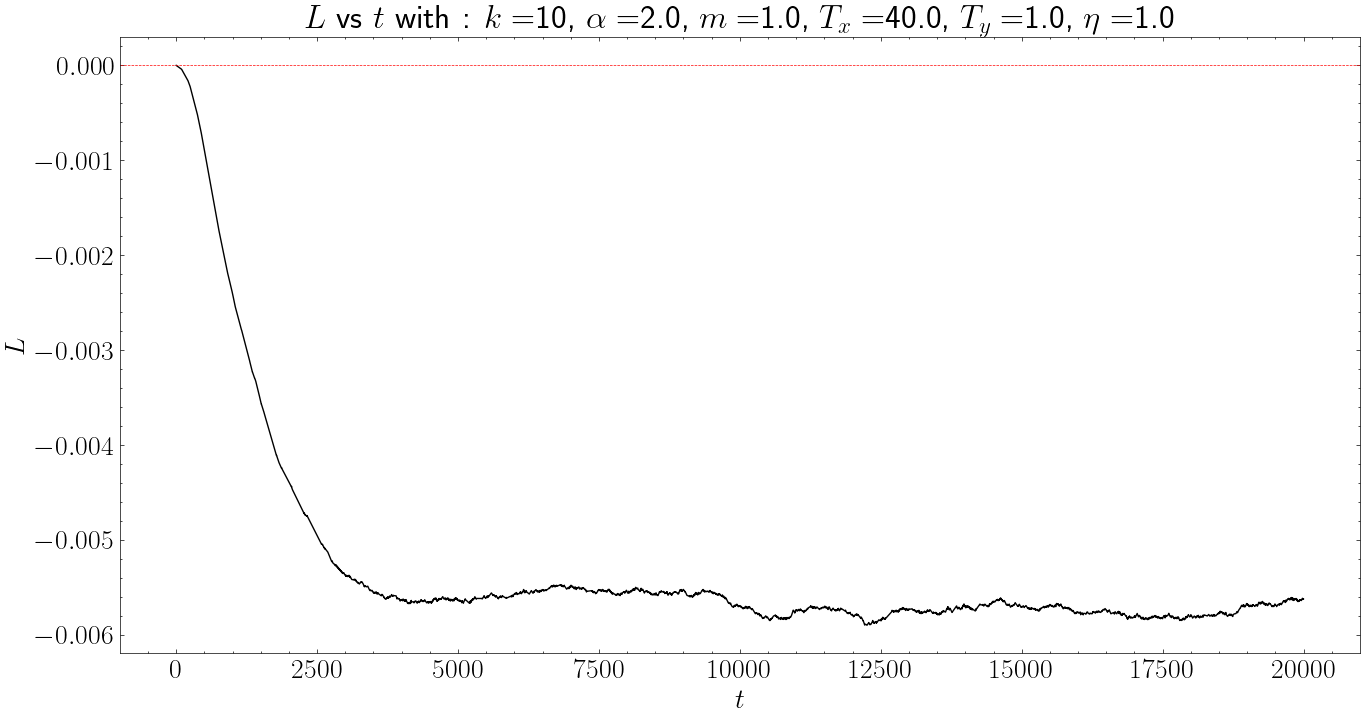

In [ ]:
plt.figure(figsize=(16,8))
# plt.plot( np.arange(0,nsteps), angularmomentum(trajectory), color='k', lw=1)
# plt.scatter(0, angularmomentum(trajectory)[0], color='b', s=100, label='Start')

# plt.scatter(nsteps-1, angularmomentum(trajectory)[-1], color='r', s=100, label='End')
plt.plot( np.arange(0,nsteps), L, color='k', lw=1)
plt.axhline(0, color='r', lw=0.5, ls='--')
plt.xlabel(r'$t$')
plt.ylabel(r'$L$')
plt.title(r'$L$ vs $t$ with : $k=$'+str(k)+r', $\alpha=$'+str(alpha)+r', $m=$'+str(m)+r', $T_x=$'+str(T[0])+r', $T_y=$'+str(T[1])+r', $\eta=$'+str(eta))
# plt.savefig('images/gyrator/udgyrator_LDTlarge_1_long.png', dpi=300)

Text(0, 0.5, 'Y')

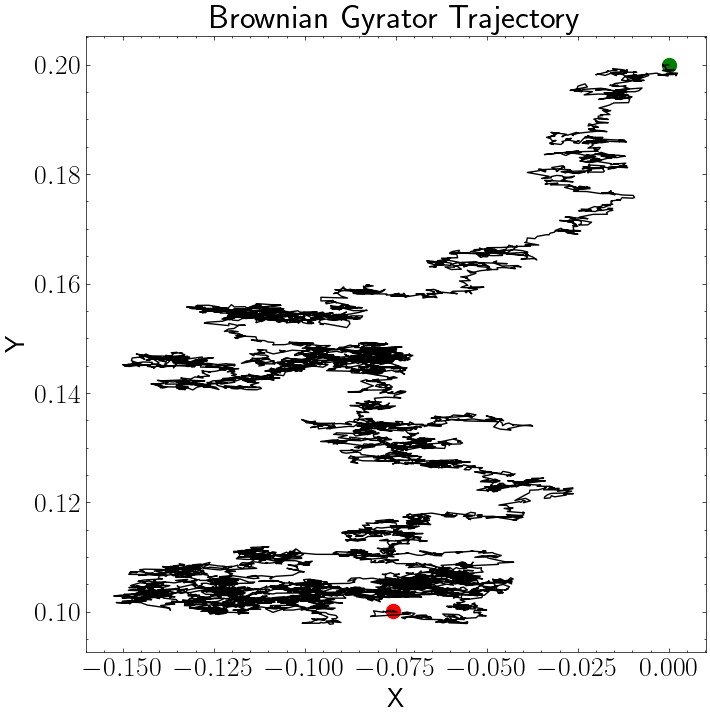

In [90]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x, y, color='k')
ax.scatter(x[0], y[0], color='green', s=100, label='Start')
ax.scatter(x[-1], y[-1], color='red', s=100, label='End')
ax.set_title('Brownian Gyrator Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [169]:
# Define the potential function for the Brownian gyrator
def potentialbr(x, y, k, alpha):
    """
    Potential for Brownian gyrator: U(x,y) = (1/2)k(x² + y²) + αxy
    """
    return 0.5 * k * (x**2 + y**2) + alpha * x * y

# Generate potential contour data
def generate_potential_grid(k, alpha, x_range, y_range, n_points=100):
    """
    Generate grid for potential contour plot
    """
    x = np.linspace(x_range[0], x_range[1], n_points)
    y = np.linspace(y_range[0], y_range[1], n_points)
    X, Y = np.meshgrid(x, y)
    Z = potentialbr(X, Y, k, alpha)
    return X, Y, Z

In [151]:
nsteps=2000
k = 1.999
alpha = 0.99
dt=0.003
# T1 = [0,0]
T = [100.01,.002]
ini = [0.0, 0.0]
trajectory = bgyrator(k, alpha, T, eta, ini, dt, nsteps)
x, y = np.mgrid[-1.5:1.5:.01,     -1.5:1.5:.01]
potential = 0.5 * (k*(x**2 + y**2)) + alpha*x*y
# plt.contour(x, y, potential, levels=3, cmap='binary')
time = np.arange(0, nsteps*dt, dt)

# Determine plot limits based on trajectory with some padding
x_min, x_max = trajectory[:, 0].min(), trajectory[:, 0].max()
y_min, y_max = trajectory[:, 1].min(), trajectory[:, 1].max()
padding = 0.06
x_range = (x_min - 2*padding, x_max + 2*padding)
y_range = (y_min - padding, y_max + padding)

# Generate potential contour data
X, Y, Z = generate_potential_grid(k, alpha, x_range, y_range, n_points=200)


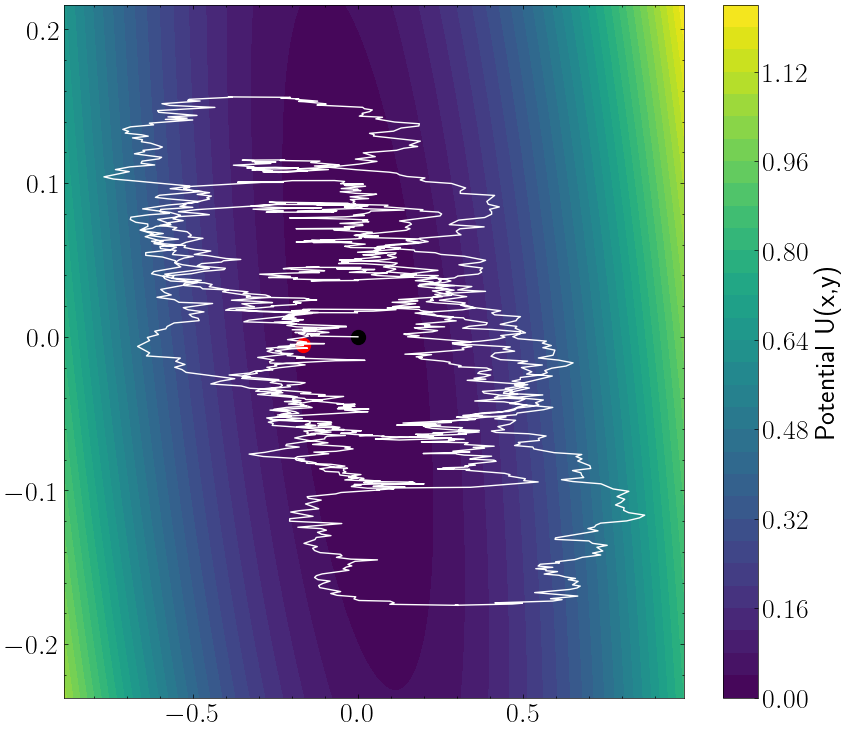

In [152]:
plt.figure(figsize=(10, 9))
contour = plt.contourf(X, Y, Z, levels=30, cmap='viridis')
plt.colorbar(contour, label='Potential U(x,y)')
plt.plot(trajectory[:, 0], trajectory[:, 1], color='white', lw=1)
plt.scatter(trajectory[0, 0], trajectory[0, 1], color='black', s=100, label='Start')
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=100, label='End')

In [63]:
import matplotlib.style as mplstyle
mplstyle.use('fast')


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.



Generating simple animation...
Frame 1/2000
Frame 1/2000
Frame 1/2000
Frame 1/2000
Frame 2/2000
Frame 3/2000
Frame 4/2000
Frame 5/2000
Frame 6/2000
Frame 7/2000
Frame 8/2000
Frame 9/2000
Frame 10/2000
Frame 11/2000
Frame 12/2000
Frame 13/2000
Frame 14/2000
Frame 15/2000
Frame 16/2000
Frame 17/2000
Frame 18/2000
Frame 19/2000
Frame 20/2000
Frame 21/2000
Frame 22/2000
Frame 23/2000
Frame 24/2000
Frame 25/2000
Frame 26/2000
Frame 27/2000
Frame 28/2000
Frame 29/2000
Frame 30/2000
Frame 31/2000
Frame 32/2000
Frame 33/2000
Frame 34/2000
Frame 35/2000
Frame 36/2000
Frame 37/2000
Frame 38/2000
Frame 39/2000
Frame 40/2000
Frame 41/2000
Frame 42/2000
Frame 43/2000
Frame 44/2000
Frame 45/2000
Frame 46/2000
Frame 47/2000
Frame 48/2000
Frame 49/2000
Frame 50/2000
Frame 51/2000
Frame 52/2000
Frame 53/2000
Frame 54/2000
Frame 55/2000
Frame 56/2000
Frame 57/2000
Frame 58/2000
Frame 59/2000
Frame 60/2000
Frame 61/2000
Frame 62/2000
Frame 63/2000
Frame 64/2000
Frame 65/2000
Frame 66/2000
Frame 67/2000


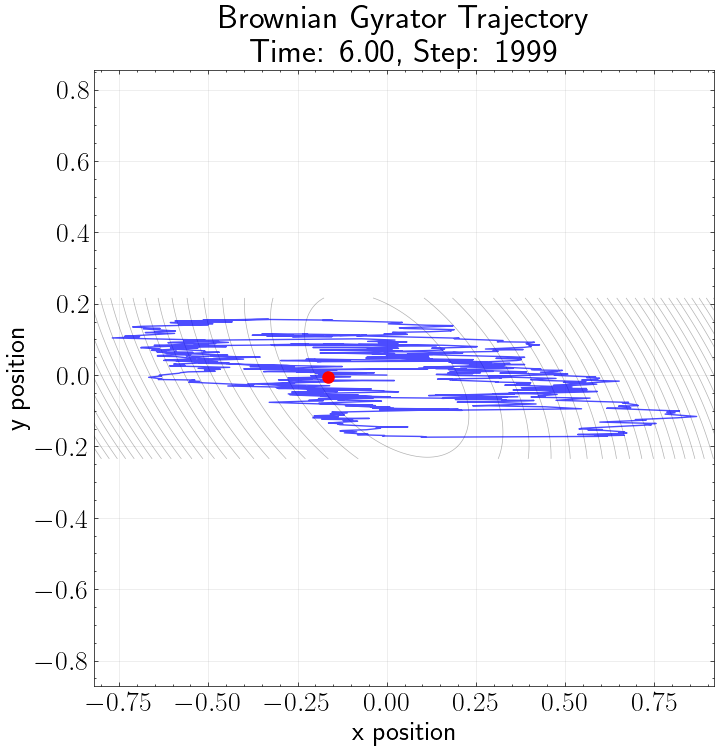

In [153]:

# Create the figure and axis
print("\nGenerating simple animation...")
fig_simple, ax_simple = plt.subplots(figsize=(8, 8))
ax_simple.set_xlim(trajectory[:, 0].min() - 0.05, trajectory[:, 0].max() + 0.05)
ax_simple.set_ylim(trajectory[:, 1].min() - 0.05, trajectory[:, 1].max() + 0.05)
ax_simple.set_xlabel('x position')
ax_simple.set_ylabel('y position')
contour_lines_simple = ax_simple.contour(X, Y, Z, levels=30, colors='black', alpha=0.3, linewidths=0.5)
ax_simple.set_title('Brownian Gyrator Trajectory Animation')
ax_simple.grid(True, alpha=0.3)
ax_simple.set_aspect('equal', adjustable='datalim')

line, = ax_simple.plot([], [], 'b-', alpha=0.7, lw=1)
point, = ax_simple.plot([], [], 'ro', markersize=8)

def update_simple(frame):
    line.set_data(trajectory[:frame+1, 0], trajectory[:frame+1, 1])
    point.set_data([trajectory[frame, 0]], [trajectory[frame, 1]])
    ax_simple.set_title(f'Brownian Gyrator Trajectory\nTime: {time[frame]:.2f}, Step: {frame}')
    print(f'Frame {frame+1}/{nsteps}')
    return line, point

ani_simple = FuncAnimation(fig_simple, update_simple, frames=nsteps, interval=20, blit=True)
ani_simple.save('images/gyrator/bg_anim_LargeDT_u0_test2.mp4', writer='ffmpeg', dpi=300)



In [154]:
print("\n" + "="*60)
print("POTENTIAL INFORMATION:")
print("="*60)
print(f"Potential function: U(x,y) = (1/2)*{k}*(x² + y²) + {alpha}*x*y")
print(f"Minimum at: (0, 0)")
print(f"Potential at origin: U(0,0) = 0")
print(f"Potential curvature:")
print(f"  ∂²U/∂x² = k = {k}")
print(f"  ∂²U/∂y² = k = {k}")
print(f"  ∂²U/∂x∂y = α = {alpha}")
print(f"Eigenvalues of Hessian: {k - alpha}, {k + alpha}")
print("="*60)


POTENTIAL INFORMATION:
Potential function: U(x,y) = (1/2)*1.999*(x² + y²) + 0.99*x*y
Minimum at: (0, 0)
Potential at origin: U(0,0) = 0
Potential curvature:
  ∂²U/∂x² = k = 1.999
  ∂²U/∂y² = k = 1.999
  ∂²U/∂x∂y = α = 0.99
Eigenvalues of Hessian: 1.0090000000000001, 2.989


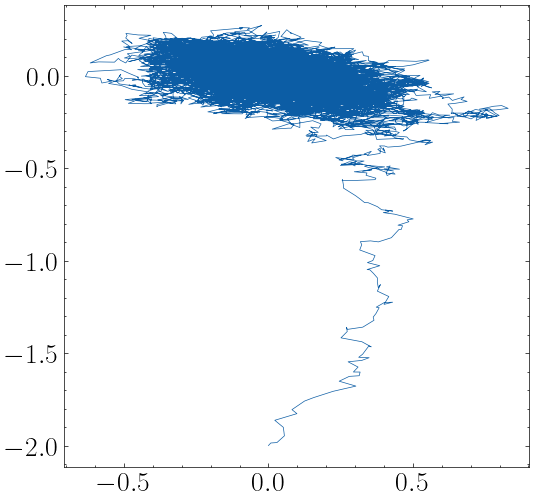

In [49]:
plt.figure(figsize=(6,6))
plt.plot(x, y, lw=0.5)

In [61]:
RUNS = 10000
xyruns = np.zeros((nsteps, 2, RUNS))
for i in range(RUNS):
    ini = np.random.uniform(-0.2,0.2,2)
    xyruns[:,:,i] = bgyrator(k, alpha, T, eta, ini, dt, nsteps)


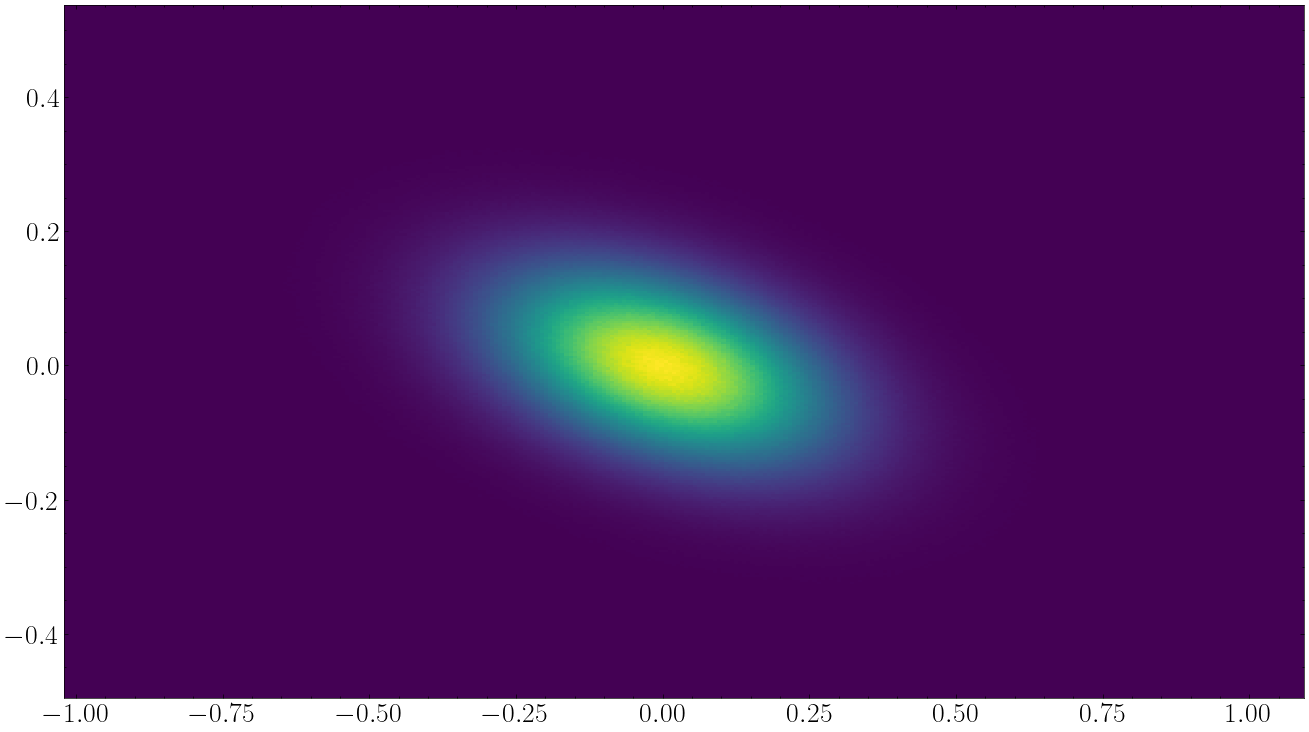

In [57]:
ct = 2000
plt.figure(figsize=(16,9))
counts,ybins,xbins, image= plt.hist2d(xyruns[ct:,0,:].flatten(), xyruns[ct:,1,:].flatten(), bins=300)


In [62]:
mean  = [0,0]

def C_xx_matrix(k, alpha, T):
    """
    Compute the C_xx matrix.

    Parameters
    ----------
    k : float
        Scalar k
    alpha : float
        Scalar alpha (replaces u)
    T : array-like of length 2
        T[0] = T1, T[1] = T2

    Returns
    -------
    2x2 numpy array
    """

    T1 = T[0]
    T2 = T[1]

    prefactor = 1.0 / (2 * k * (k**2 - alpha**2))

    M = np.array([
        [2*T1*k**2 + (T2 - T1)*alpha**2,  -(T1 + T2)*k*alpha],
        [-(T1 + T2)*k*alpha,              2*T2*k**2 + (T1 - T2)*alpha**2]
    ])

    return prefactor * M
covmat = C_xx_matrix(k, alpha, T)

0.008527367277158976


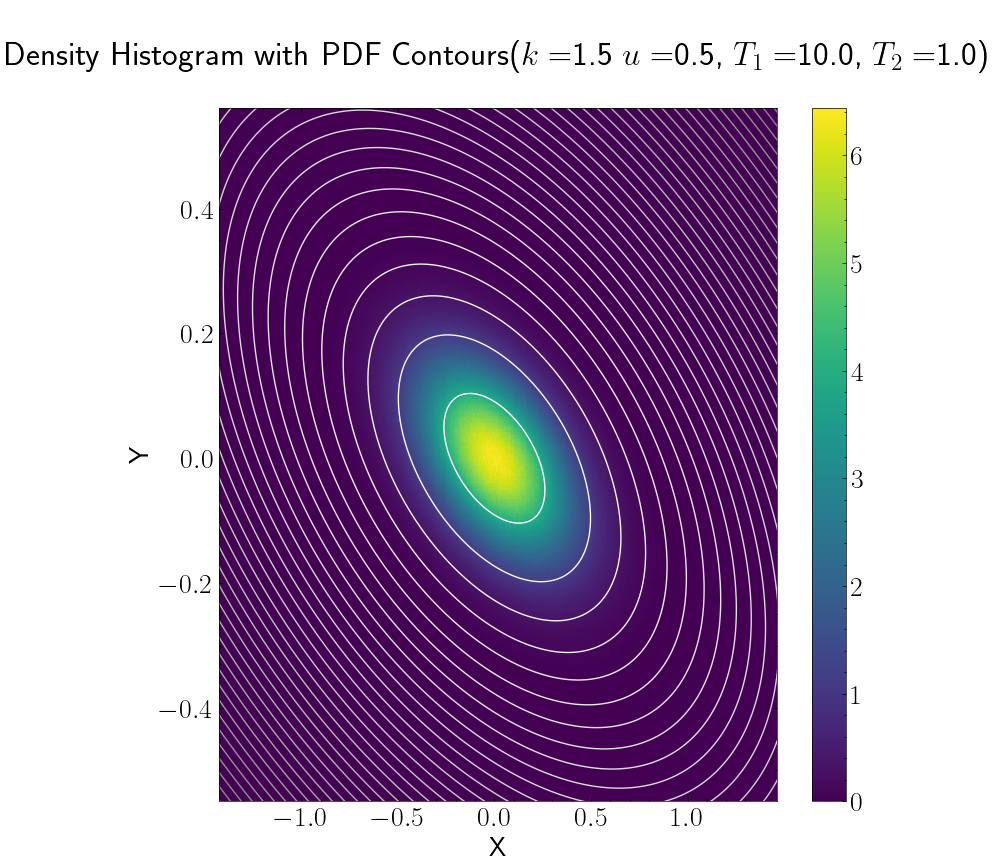

In [64]:
from scipy.stats import multivariate_normal

x, y = np.mgrid[-1.5:1.5:.01,     -1.5:1.5:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, covmat)


# fig2,ax2 = plt.subplots(1,1,figsize=(16,9))
plt.figure(figsize=(9,9))
print(rv.pdf(pos)[0,0])

# # ax = ax2[0]
# ax.contourf(x, y, rv.pdf(pos), norm ="linear")
potential = 0.5 * (k*(x**2 + y**2)) + alpha*x*y

potential = 0.5 * (k*(x**2 + y**2)) + alpha*x*y
plt.contour(x, y, rv.pdf(pos), levels=70, cmap='gray',zorder=2)
counts,ybins,xbins, image= plt.hist2d(xyruns[ct:,0,:].flatten(), xyruns[ct:,1,:].flatten(), bins=300, density=True, cmap = 'viridis')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('\n Density Histogram with PDF Contours('+r"$k = $"+str(k)+r" $u = $"+str(alpha)+r", $T_1=$"+str(T[0])+r", $T_2=$"+str(T[1])+")\n")
plt.savefig('images/gyrator/gyrator_density11.png', dpi=300, bbox_inches='tight')
# plt.xlim(-1,1)
# plt.ylim(-1,1)

# plt.imshow(counts)
# plt.contour(x, y, potential, levels=3, cmap='binary')



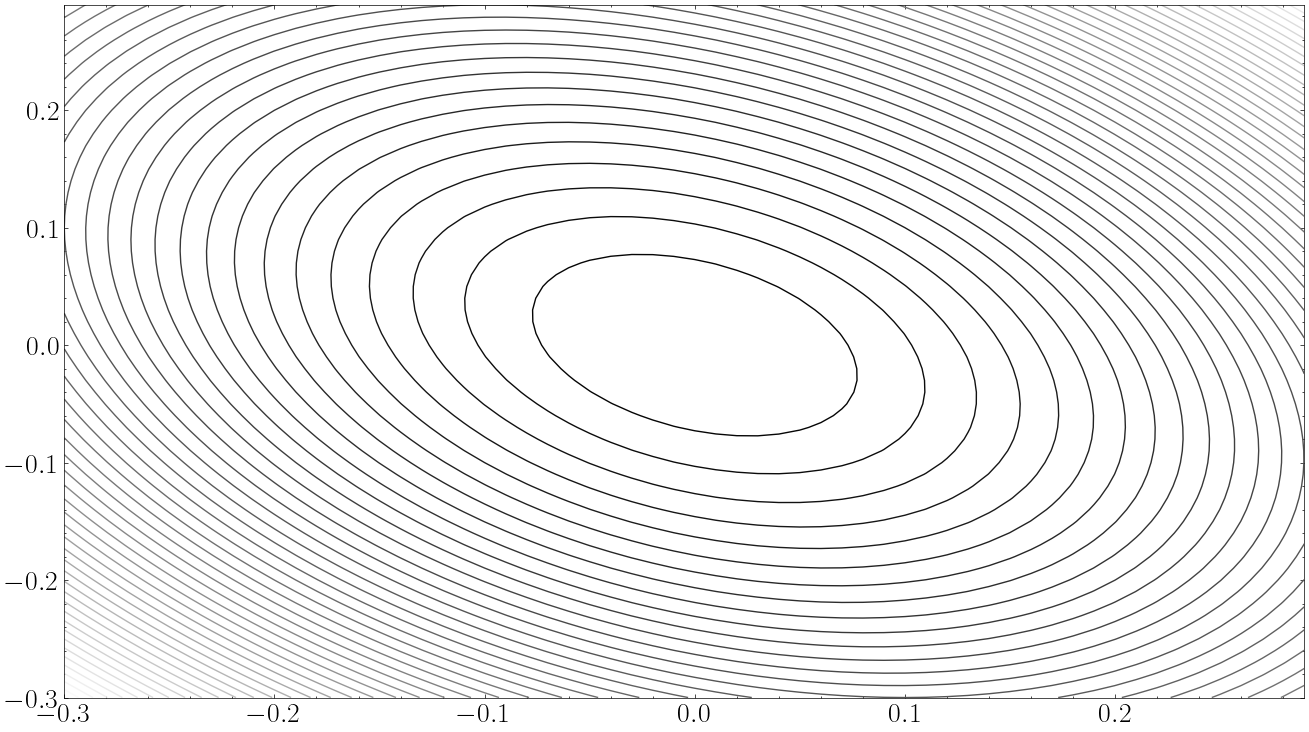

In [ ]:
plt.figure(figsize=(16,9))
x,y = np.mgrid[-0.3:0.3:.01, -0.3:0.3:.01]
pos = np.dstack((x, y))
